In [2]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install -U sentence-transformers
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TFXLNetModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds


import re

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 4.3 MB 70.0 MB/s 
     |████████████████████████████████| 596 kB 74.9 MB/s 
     |████████████████████████████████| 895 kB 71.0 MB/s 
     |████████████████████████████████| 6.6 MB 70.3 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 23.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=f64186cd648ebfac59b0814c16566b1834fd3f2563b1c6c302d774d3ca56daf0
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [2]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [3]:
def load_data():
  data_df = pd.read_csv("/content/drive/MyDrive/MMAI 891_Group Assignment/public_data.csv")
  return data_df

orig_data = load_data()
orig_data

,id,message,label
0,10480,start the robotic vacuum,iot_cleaning
1,4210,i am sorry but i think you are not right.,general_negate
2,2443,what is the time difference between california...,datetime_convert
3,5869,tell me my list names,lists_query
4,2801,beep when i get an email from john,email_query
...,...,...,...
8879,9708,search for a train ticket to newcastle,transport_ticket
8880,8278,is there a food festival in the area,recommendation_events
8881,10509,make the lights blue in here,iot_hue_lightchange
8882,7046,play from favorites song,play_music


In [4]:
# Encode the labels
orig_data['encoded_label'] = orig_data['label'].astype('category').cat.codes
b = orig_data['label'].astype('category')

#Create the category mapping to map it back
cat_map = dict(enumerate(b.cat.categories))
orig_data.head()

,id,message,label,encoded_label
0,10480,start the robotic vacuum,iot_cleaning,26
1,4210,i am sorry but i think you are not right.,general_negate,22
2,2443,what is the time difference between california...,datetime_convert,10
3,5869,tell me my list names,lists_query,36
4,2801,beep when i get an email from john,email_query,13


In [5]:
x_orig_data=orig_data['message']
y_orig_data=orig_data['label']

In [6]:
cat_map

{0: 'alarm_query',
 1: 'alarm_remove',
 2: 'alarm_set',
 3: 'audio_volume_down',
 4: 'audio_volume_mute',
 5: 'audio_volume_up',
 6: 'calendar_query',
 7: 'calendar_remove',
 8: 'calendar_set',
 9: 'cooking_recipe',
 10: 'datetime_convert',
 11: 'datetime_query',
 12: 'email_addcontact',
 13: 'email_query',
 14: 'email_querycontact',
 15: 'email_sendemail',
 16: 'general_affirm',
 17: 'general_commandstop',
 18: 'general_confirm',
 19: 'general_dontcare',
 20: 'general_explain',
 21: 'general_joke',
 22: 'general_negate',
 23: 'general_praise',
 24: 'general_quirky',
 25: 'general_repeat',
 26: 'iot_cleaning',
 27: 'iot_coffee',
 28: 'iot_hue_lightchange',
 29: 'iot_hue_lightdim',
 30: 'iot_hue_lightoff',
 31: 'iot_hue_lighton',
 32: 'iot_hue_lightup',
 33: 'iot_wemo_off',
 34: 'iot_wemo_on',
 35: 'lists_createoradd',
 36: 'lists_query',
 37: 'lists_remove',
 38: 'music_likeness',
 39: 'music_query',
 40: 'music_settings',
 41: 'news_query',
 42: 'play_audiobook',
 43: 'play_game',
 44

In [7]:
def load_data():
  data_df = pd.read_csv("/content/drive/MyDrive/MMAI 891_Group Assignment/personal_assistant_test.csv")
  return data_df

df_test = load_data()
print(df_test.info())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2221 non-null   int64 
 1   message  2221 non-null   object
dtypes: int64(1), object(1)
memory usage: 34.8+ KB
None
      id                                     message
0  10873  list the current price of microsoft shares
1   8491             where is the nearest smoke shop
2   4549                          please start over.
3   5948                         read my lists to me
4   1663                             mute volume now


In [8]:
X_test=df_test['message']

In [9]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_encode = labelencoder.fit_transform(y_orig_data)

In [10]:
orig_data.drop_duplicates(inplace= True)

In [11]:
from sklearn.model_selection import train_test_split

X=orig_data['message']
Y=orig_data['label']
from sentence_transformers import SentenceTransformer, LoggingHandler

embedder = SentenceTransformer(
    model_name_or_path="roberta-large-nli-stsb-mean-tokens")
X_embeddings = embedder.encode(X, convert_to_numpy=True)
X_embeddings

array([[ 3.2774180e-01, -5.6105822e-01,  2.5259039e-01, ...,
         5.4890901e-02,  2.2835223e-01, -4.5567778e-01],
       [-7.6021714e-04,  8.9108005e-02,  2.3945440e-01, ...,
        -6.7759585e-01, -5.5434680e-01,  1.7269918e-01],
       [-3.4704775e-01,  1.0437894e+00, -3.5435580e-02, ...,
        -2.5184855e-01, -1.3075087e+00,  3.1813395e-01],
       ...,
       [-1.0797985e+00,  6.3636816e-01, -2.7796361e-01, ...,
         1.1009067e+00, -1.7884252e+00, -1.0352412e+00],
       [-1.1665739e+00,  1.1652147e+00, -3.3257738e-01, ...,
         7.8300339e-01, -1.1192614e+00,  7.0742297e-01],
       [-1.4765394e-01,  8.3939284e-01, -4.0881649e-01, ...,
         2.1015219e-01, -5.1304466e-01,  4.6797314e-01]], dtype=float32)

In [12]:
X_embeddings.shape

(8884, 1024)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_embeddings, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)

(7107, 1024)
(1777, 1024)


In [14]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(n_estimators=500, max_depth=20, learning_rate=0.001)
clf_xg.fit(X_train, y_train)


XGBClassifier(learning_rate=0.001, max_depth=20, n_estimators=500,
              objective='multi:softprob')

In [15]:
y_val_pred =clf_xg.predict(X_val)

In [16]:

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

adjusted_rand = adjusted_rand_score(y_val, y_val_pred)
adjusted_mutual_info = adjusted_mutual_info_score(y_val, y_val_pred)

print("ARI: {}".format(adjusted_rand))
print("AMI: {}".format(adjusted_mutual_info))

[[26  0  3 ...  0  0  0]
 [ 1 20  1 ...  0  0  0]
 [ 0  0 24 ...  1  0  0]
 ...
 [ 0  0  0 ... 24  1  0]
 [ 0  0  0 ...  1 28  1]
 [ 0  0  0 ...  0  0 27]]
                          precision    recall  f1-score   support

             alarm_query       0.96      0.90      0.93        29
            alarm_remove       0.91      0.87      0.89        23
               alarm_set       0.67      0.83      0.74        29
       audio_volume_down       0.50      0.50      0.50        12
       audio_volume_mute       0.70      0.70      0.70        23
         audio_volume_up       0.73      0.79      0.76        24
          calendar_query       0.62      0.52      0.56        31
         calendar_remove       0.82      0.87      0.84        31
            calendar_set       0.57      0.62      0.59        34
          cooking_recipe       0.83      0.71      0.77        35
        datetime_convert       0.56      0.38      0.45        13
          datetime_query       0.60      0.80      

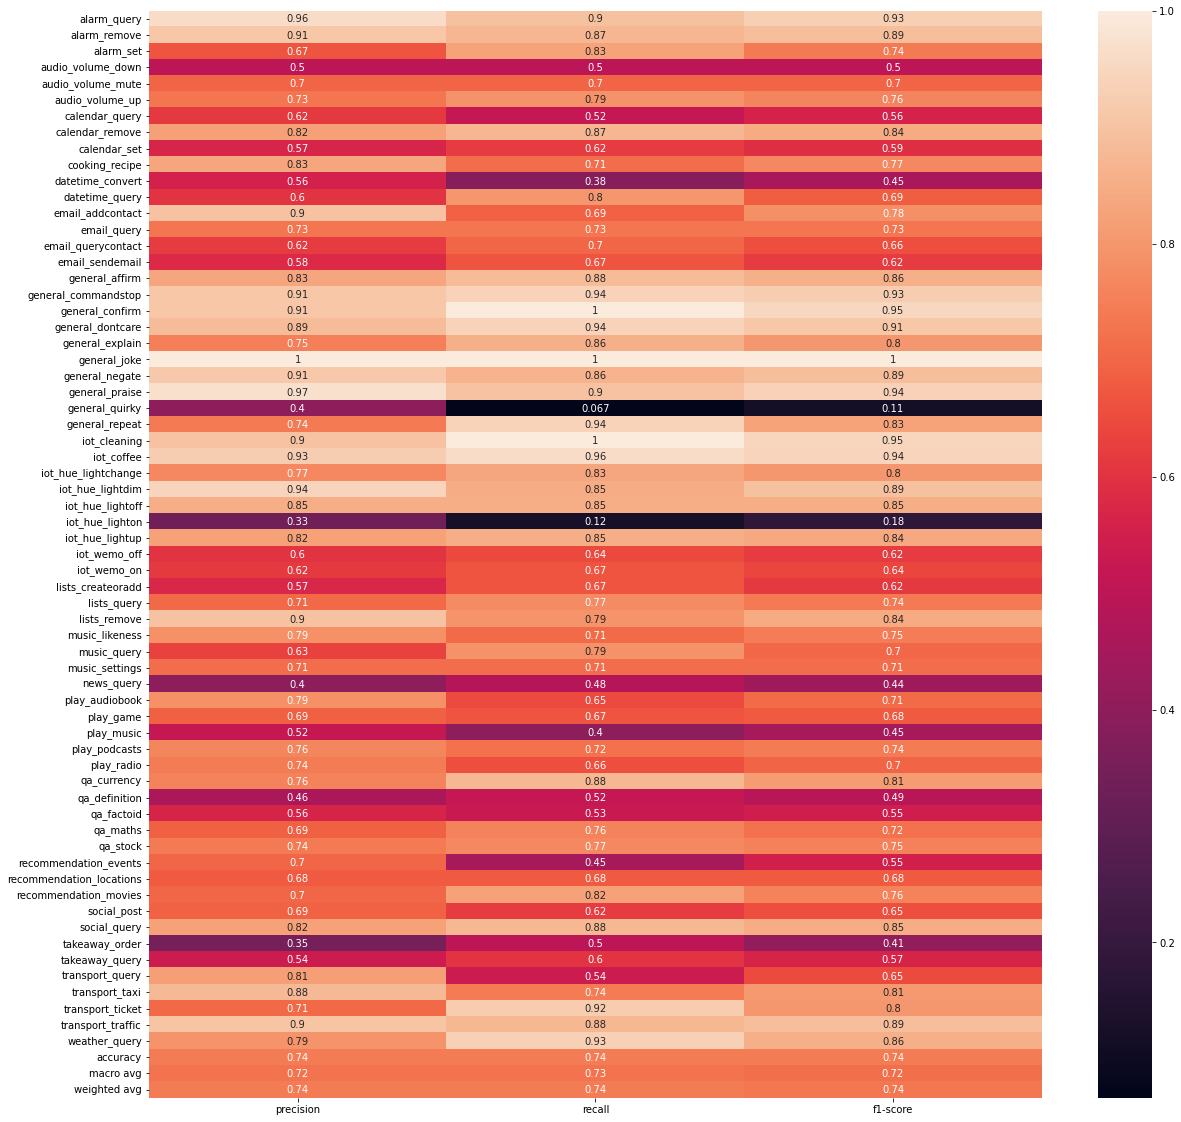

In [17]:
import seaborn as sns
def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(y_val, y_val_pred, cat_map)

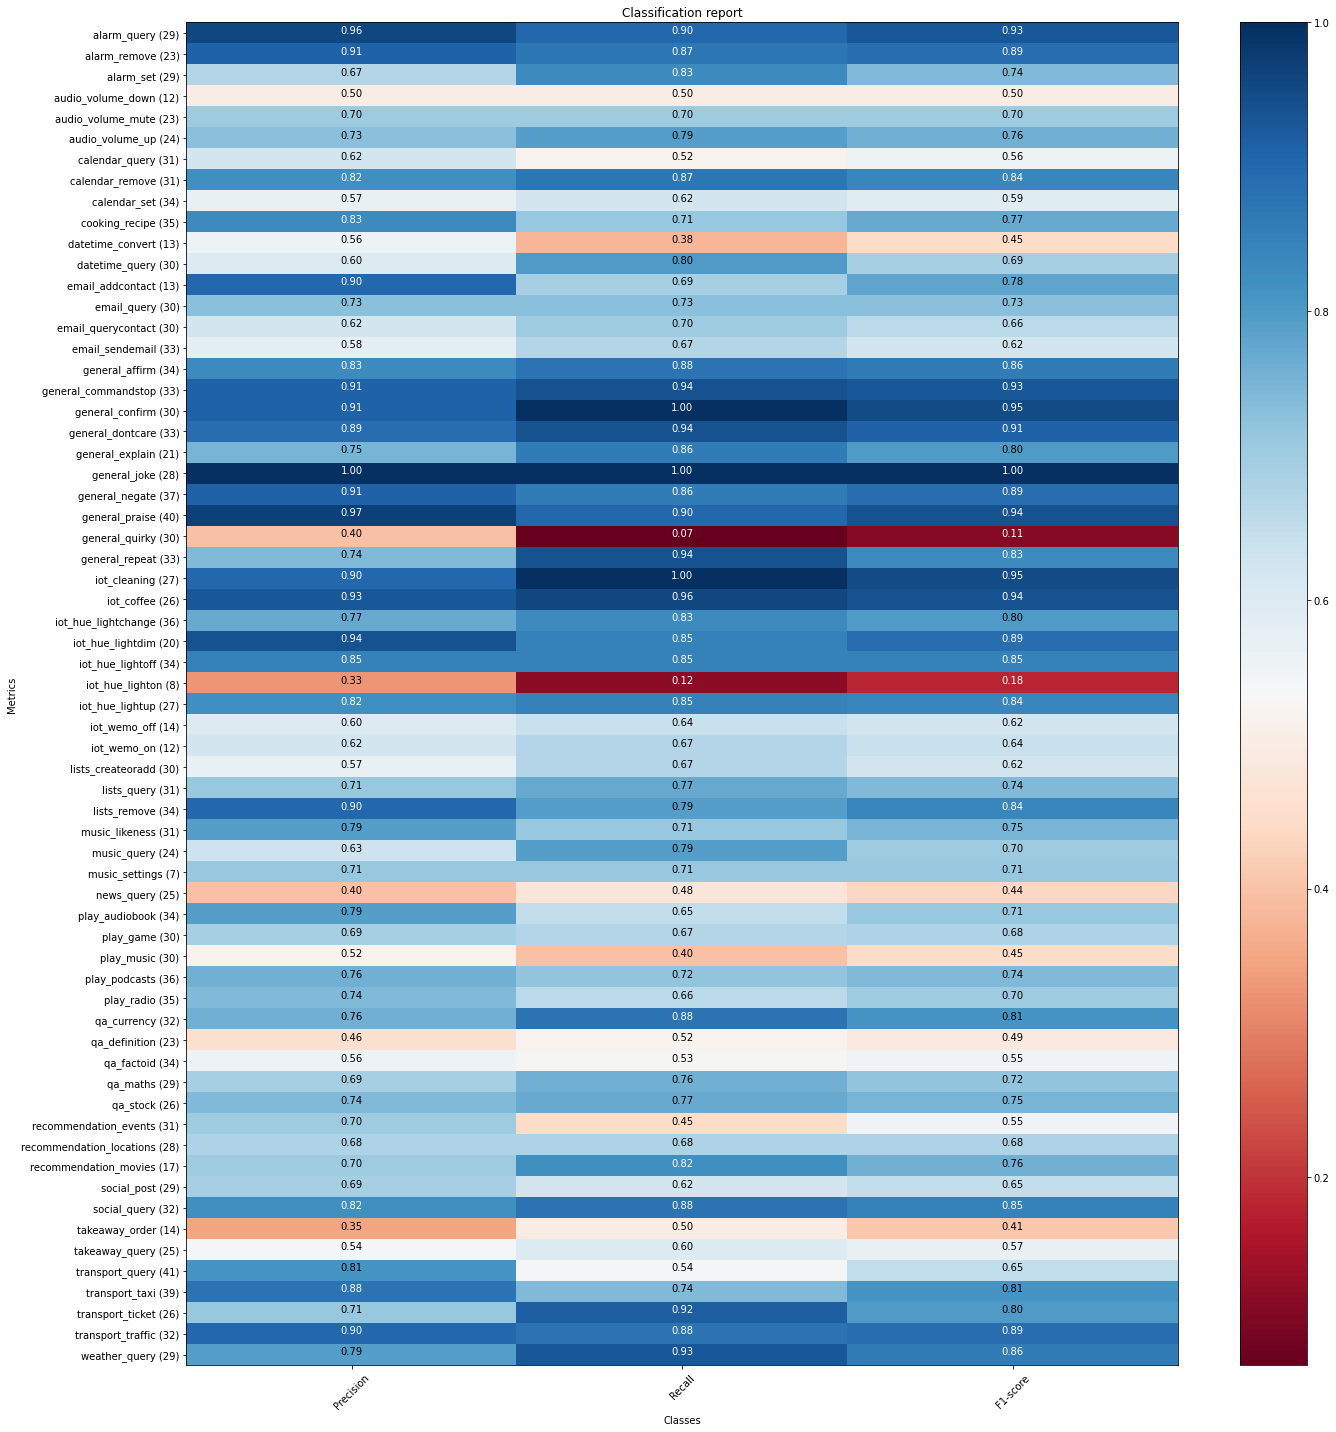

In [18]:
import itertools

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(y_val, y_val_pred, target_names = list(cat_map.values()))

plot_classification_report(classificationReport)

In [19]:
x_test_embeddings = embedder.encode(X_test, convert_to_numpy=True)

In [20]:
y_test_pred =clf_xg.predict(x_test_embeddings)

In [ ]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': y_test_pred_inversed})

print(my_submission.head())
my_submission.to_csv('Submission_RobertaLargeNLI_XGBoost.csv', index=False)

#Split Data

## Training Data Split